In [1]:
import numpy as np
import torch_geometric
print(torch_geometric.__version__)

def calculate_force(particle1, particle2):
    dx = particle2[0] - particle1[0]
    dy = particle2[1] - particle1[1]
    r_squared = dx**2 + dy**2
    
    if r_squared == 0:
        return [0, 0]  # Avoid division by zero
    
    force_magnitude = particle1[2] * particle2[2] / r_squared
    force_x = force_magnitude * dx / np.sqrt(r_squared)
    force_y = force_magnitude * dy / np.sqrt(r_squared)
    
    return [force_x, force_y]

def generate_particle_dataset(num_points):
    dataset = []
    
    for _ in range(num_points):
        data_point = []
        positions = set()
        
        # Generate 3 particles with unique positions
        for _ in range(3):
            while True:
                x = np.random.uniform(0, 1)
                y = np.random.uniform(0, 1)
                position = (round(x, 6), round(y, 6))
                
                if position not in positions:
                    positions.add(position)
                    break
            
            # mass = np.random.uniform(0.5, 10) # Commented to make training easier for now
            mass = 1
            particle = [x, y, mass, [0, 0]]  # [x, y, mass, [force_x, force_y]]
            data_point.append(particle)
        
        # Calculate forces
        for i in range(3):
            for j in range(3):
                if i != j:
                    force = calculate_force(data_point[i], data_point[j])
                    data_point[i][3][0] += force[0]
                    data_point[i][3][1] += force[1]
        
        dataset.append(data_point)
    
    return dataset

# Generate a dataset with 100 data points
num_points = 20
particle_dataset = generate_particle_dataset(num_points)

# Print the first few data points as an example
for i, data_point in enumerate(particle_dataset[:3]):
    print(f"Data point {i + 1}:")
    for j, particle in enumerate(data_point):
        print(f"  Particle {j + 1}: [x = {particle[0]:.6f}, y = {particle[1]:.6f}, mass = {particle[2]:.4f}, force = [{particle[3][0]:.6e}, {particle[3][1]:.6e}]]")
    print()

2.5.3
Data point 1:
  Particle 1: [x = 0.397746, y = 0.901783, mass = 1.0000, force = [8.094955e+00, -5.375993e+01]]
  Particle 2: [x = 0.136531, y = 0.591150, mass = 1.0000, force = [1.126171e+01, 8.990510e+00]]
  Particle 3: [x = 0.431132, y = 0.765166, mass = 1.0000, force = [-1.935667e+01, 4.476942e+01]]

Data point 2:
  Particle 1: [x = 0.682843, y = 0.396445, mass = 1.0000, force = [-1.098011e+01, 1.908915e+01]]
  Particle 2: [x = 0.092976, y = 0.149567, mass = 1.0000, force = [3.923010e+00, 2.408193e+00]]
  Particle 3: [x = 0.597430, y = 0.592583, mass = 1.0000, force = [7.057099e+00, -2.149734e+01]]

Data point 3:
  Particle 1: [x = 0.200476, y = 0.917057, mass = 1.0000, force = [2.361692e+00, -1.059486e+00]]
  Particle 2: [x = 0.940936, y = 0.913250, mass = 1.0000, force = [-2.300316e+00, -1.202263e+00]]
  Particle 3: [x = 0.620185, y = 0.097661, mass = 1.0000, force = [-6.137604e-02, 2.261749e+00]]



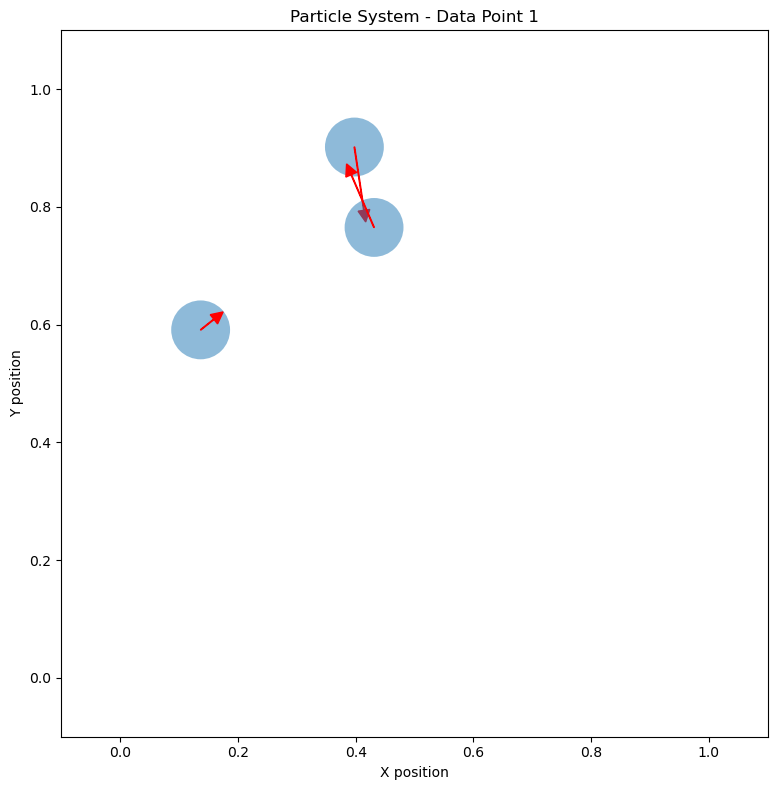

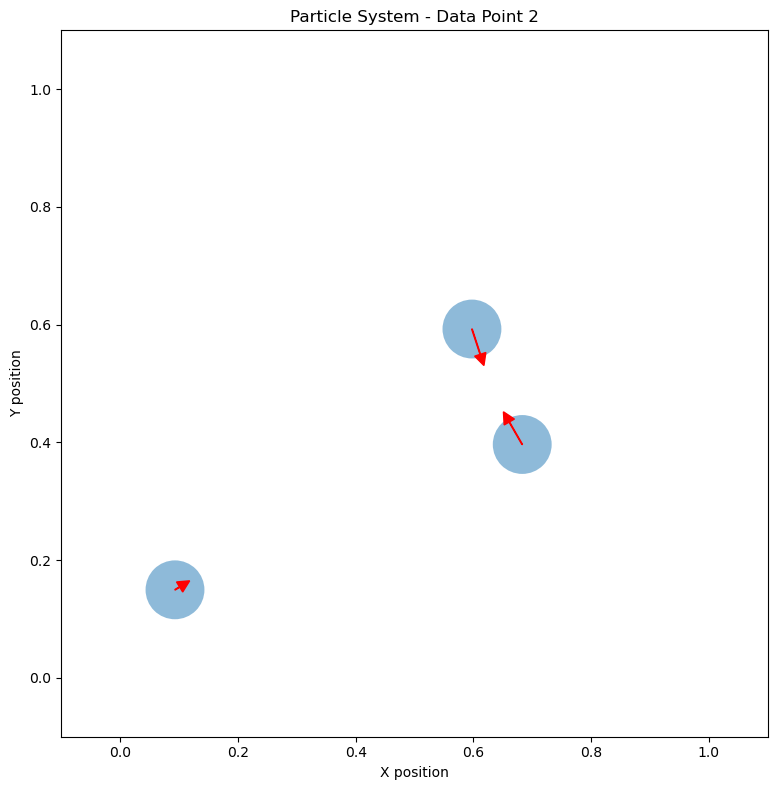

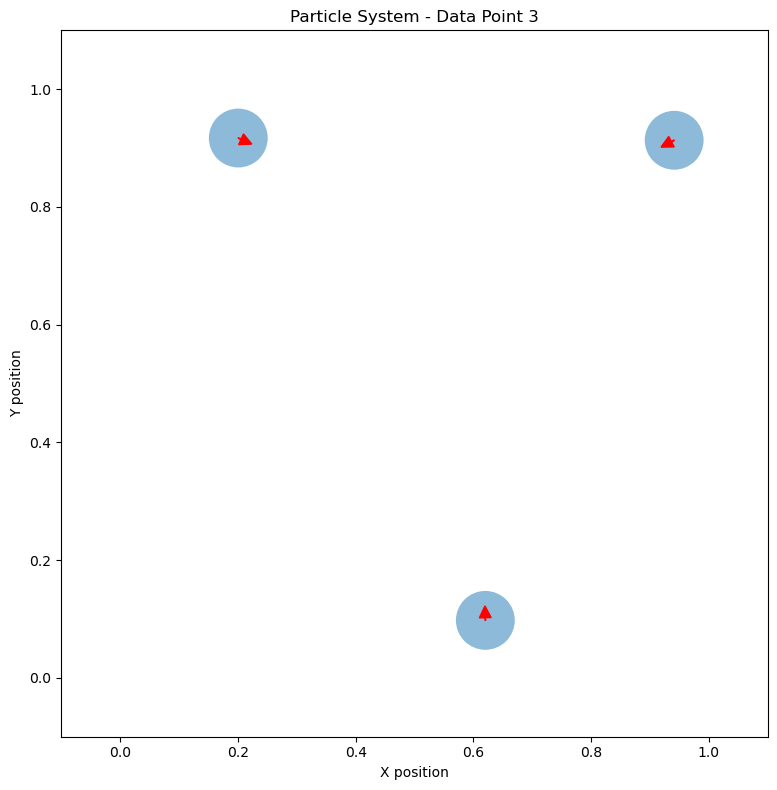

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_particle_system(data_point, index):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Set plot limits
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    
    # Find the maximum mass for scaling
    max_mass = max(particle[2] for particle in data_point)
    
    # Plot particles and forces
    for particle in data_point:
        x, y, mass, force = particle
        
        # Plot particle as a circle
        radius = (mass / max_mass) / 20  # Scale size relative to maximum mass
        circle = plt.Circle((x, y), radius=radius, fill=True, alpha=0.5)
        ax.add_artist(circle)
        
        # Plot force arrow
        force_x, force_y = force
        # Scale arrow length
        scale = 0.002
        ax.arrow(x, y, force_x * scale, force_y * scale, 
                    head_width=0.02, head_length=0.02, fc='r', ec='r')
    
    ax.set_aspect('equal')
    ax.set_title(f'Particle System - Data Point {index}')
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    
    plt.tight_layout()
    plt.show()

# Assuming particle_dataset is already generated
# Plot the first 3 data points
for i, data_point in enumerate(particle_dataset[:3]):
    plot_particle_system(data_point, i+1)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data

class EdgeModel(MessagePassing):
    def __init__(self):
        super(EdgeModel, self).__init__(aggr='add')  # "Add" aggregation.
        self.mlp = nn.Sequential(
            nn.Linear(6, 300),  # 6 = 2 (pos) + 1 (mass) for each particle
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, 2)  # Output 2D force
        )

    def forward(self, x, edge_index):
        # print("edge index: ", edge_index)
        return self.propagate(edge_index, x=x)

    def message(self, x_i, x_j):
        tmp = torch.cat([x_i, x_j], dim=1)  # Concatenate features of both nodes
        # print(tmp)
        out = self.mlp(tmp)
        # print("out: ", out)
        return out

class NodeModel(nn.Module):
    def __init__(self):
        super(NodeModel, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(5, 32),  # 5 = 2 (pos) + 1 (mass) + 2 (aggregated force)
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 2)  # Output 2D force
        )

    def forward(self, x, edge_index, edge_attr):
        # The edge attributes have already been added when the Message Passing layer was
        # applied. Simply concatenate them with the node's features.
        # print("edge attributes: ", edge_attr)
        out = torch.cat([x, edge_attr], dim=1)
        return self.mlp(out)

class ParticleGNN(nn.Module):
    def __init__(self):
        super(ParticleGNN, self).__init__()
        self.edge_model = EdgeModel()
        self.node_model = NodeModel()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Edge Model
        edge_attr = self.edge_model(x, edge_index)
        
        # Node Model
        out = self.node_model(x, edge_index, edge_attr)
        
        return out

# Create a sample input
def create_sample_data(num_particles=3):
    x = torch.rand(num_particles, 3)  # [x, y, mass] for each particle
    edge_index = torch.tensor([[0, 0, 1, 1, 2, 2],
                               [1, 2, 0, 2, 0, 1]], dtype=torch.long)
    data = Data(x=x, edge_index=edge_index)
    return data

# Initialize the model
model = ParticleGNN()

# Create sample data
data = create_sample_data()
print(data)
print("node info: ", data.x)

# Forward pass
output = model(data)

print("Input:")
print(data.x)
print("\nOutput (forces):")
print(output)


Data(x=[3, 3], edge_index=[2, 6])
node info:  tensor([[0.9750, 0.2568, 0.0661],
        [0.4461, 0.4682, 0.5904],
        [0.5884, 0.9483, 0.0907]])
Input:
tensor([[0.9750, 0.2568, 0.0661],
        [0.4461, 0.4682, 0.5904],
        [0.5884, 0.9483, 0.0907]])

Output (forces):
tensor([[ 0.1176, -0.1103],
        [ 0.1494, -0.1532],
        [ 0.1543, -0.1104]], grad_fn=<AddmmBackward0>)


In [4]:
x_dataset = []
y_dataset = []
edge_index = torch.tensor([[0, 0, 1, 1, 2, 2],
                           [1, 2, 0, 2, 0, 1]], dtype=torch.long)
for data_point in particle_dataset:
    x = torch.tensor([particle[:3] for particle in data_point], dtype=torch.float32)
    y = torch.tensor([particle[3] for particle in data_point], dtype=torch.float32)
    x_dataset.append(Data(x=x, edge_index=edge_index))
    y_dataset.append(y)


for particle in particle_dataset[:2]:
    print(particle)

print("\n")

for x in x_dataset[:2]:
    print(x.x)

print("\n")

for y in y_dataset[:2]:
    print(y)

[[0.39774602027182504, 0.9017831557802675, 1, [8.094955087900207, -53.75992880462423]], [0.13653102062563294, 0.5911501417351844, 1, [11.261712932687194, 8.990510098177223]], [0.4311316243895611, 0.765165746927738, 1, [-19.3566680205874, 44.769418706447006]]]
[[0.6828434250533432, 0.3964454297102322, 1, [-10.980108662424271, 19.089149404790877]], [0.09297608423891401, 0.14956660975598746, 1, [3.923009939352174, 2.408192518885823]], [0.5974296667212421, 0.5925830734331144, 1, [7.057098723072098, -21.4973419236767]]]


tensor([[0.3977, 0.9018, 1.0000],
        [0.1365, 0.5912, 1.0000],
        [0.4311, 0.7652, 1.0000]])
tensor([[0.6828, 0.3964, 1.0000],
        [0.0930, 0.1496, 1.0000],
        [0.5974, 0.5926, 1.0000]])


tensor([[  8.0950, -53.7599],
        [ 11.2617,   8.9905],
        [-19.3567,  44.7694]])
tensor([[-10.9801,  19.0891],
        [  3.9230,   2.4082],
        [  7.0571, -21.4973]])


In [5]:
import torch
import torch.optim as optim

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the device
model = model.to(device)

# Define a loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 30  # Define the number of epochs
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    for x, y in zip(x_dataset, y_dataset):
        # Move data to the device
        x = x.to(device)
        y = y.to(device)
        
        # Forward pass
        output = model(x)
        
        # Compute loss
        loss = criterion(output, y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    # Print loss for every 10 epochs
    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# After training, the model is ready for evaluation or further use
print("Training complete!")

Using device: cpu


/home/polg24/anaconda3/envs/tfg_env/lib/python3.12/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1718580525958/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Epoch [1/30], Loss: 285.6622
Epoch [2/30], Loss: 276.1204
Epoch [3/30], Loss: 258.2646
Epoch [4/30], Loss: 249.6541
Epoch [5/30], Loss: 273.3876
Epoch [6/30], Loss: 259.2485
Epoch [7/30], Loss: 249.6512
Epoch [8/30], Loss: 204.1337
Epoch [9/30], Loss: 266.7337
Epoch [10/30], Loss: 256.9448
Epoch [11/30], Loss: 243.6620
Epoch [12/30], Loss: 243.9544
Epoch [13/30], Loss: 311.4793
Epoch [14/30], Loss: 280.8993
Epoch [15/30], Loss: 286.4542
Epoch [16/30], Loss: 274.6374
Epoch [17/30], Loss: 268.2835
Epoch [18/30], Loss: 290.9015
Epoch [19/30], Loss: 274.8139
Epoch [20/30], Loss: 273.8295
Epoch [21/30], Loss: 265.6213
Epoch [22/30], Loss: 250.6425
Epoch [23/30], Loss: 245.6200
Epoch [24/30], Loss: 270.2496
Epoch [25/30], Loss: 253.7515
Epoch [26/30], Loss: 229.5165
Epoch [27/30], Loss: 202.6313
Epoch [28/30], Loss: 219.5240
Epoch [29/30], Loss: 192.7985
Epoch [30/30], Loss: 232.6275
Training complete!


In [6]:
# Ensure the model is in evaluation mode
model.eval()

# Move the model to the device if not already done
model = model.to(device)

# Prepare to store predictions
predicted_forces = []

# Iterate through the dataset to predict forces
for x in x_dataset:
    # Move data to the device
    x = x.to(device)
    
    # Make predictions
    with torch.no_grad():
        output = model(x)
        predicted_forces.append(output.cpu().numpy())

# Convert predicted forces to a format suitable for plotting
predicted_particle_dataset = []
for i, data_point in enumerate(particle_dataset):
    predicted_data_point = []
    for j, particle in enumerate(data_point):
        predicted_force = predicted_forces[i][j]  # Get predicted force
        particle_with_predicted_force = [particle[0], particle[1], particle[2], predicted_force.tolist()]
        predicted_data_point.append(particle_with_predicted_force)
    predicted_particle_dataset.append(predicted_data_point)

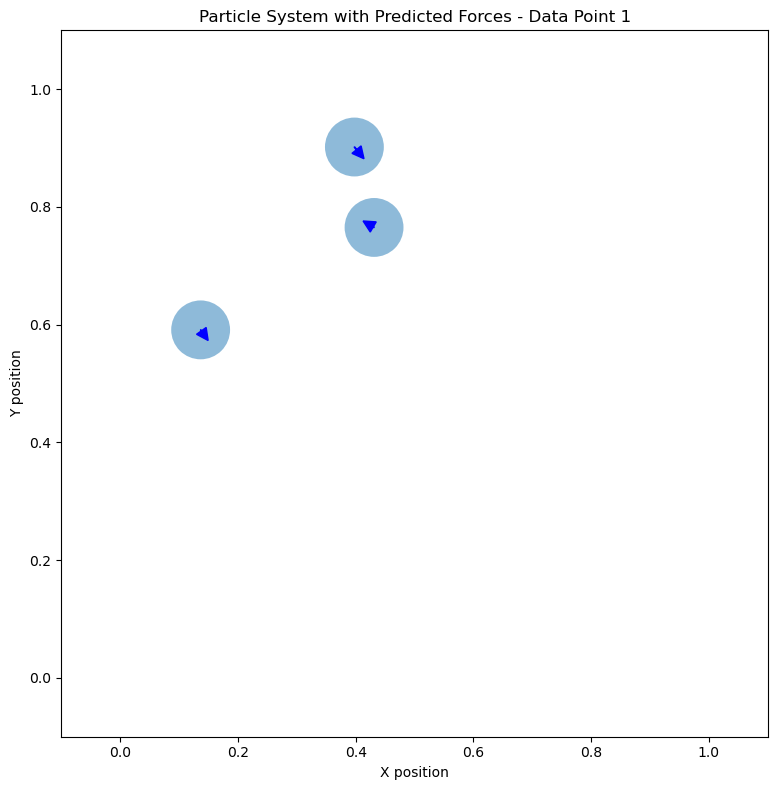

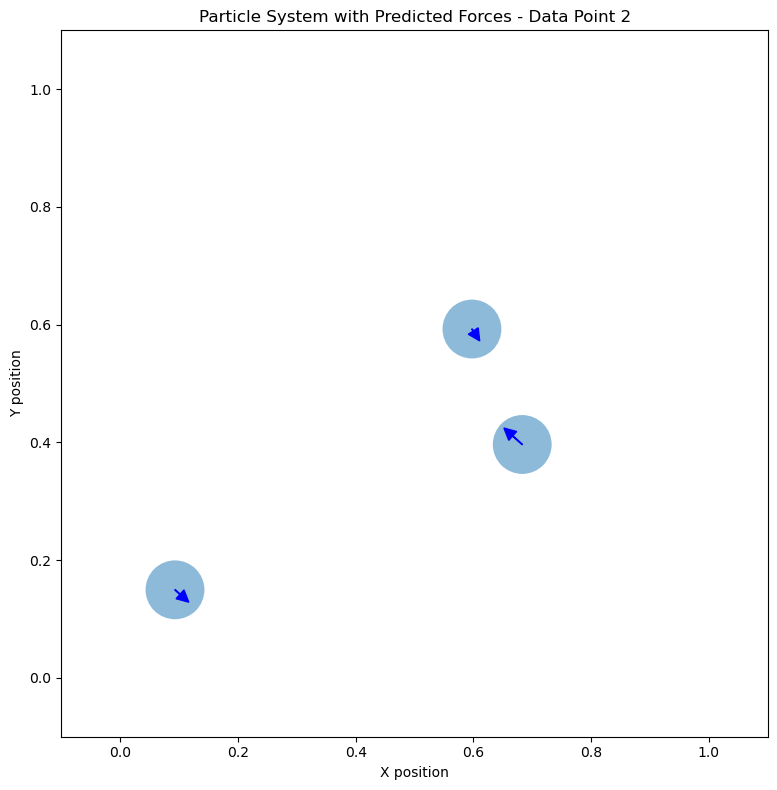

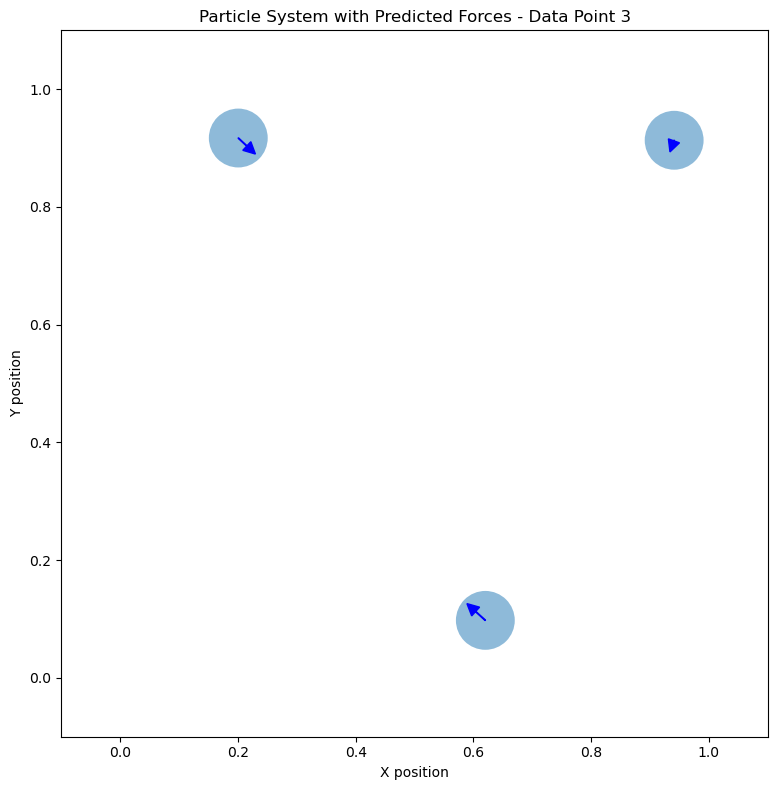

In [7]:
def plot_predicted_forces(data_point, index):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Set plot limits
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    
    # Find the maximum mass for scaling
    max_mass = max(particle[2] for particle in data_point)
    
    # Plot particles and forces
    for particle in data_point:
        x, y, mass, force = particle
        
        # Plot particle as a circle
        radius = (mass / max_mass) / 20  # Scale radius relative to maximum mass
        circle = plt.Circle((x, y), radius=radius, fill=True, alpha=0.5)
        ax.add_artist(circle)
        
        # Plot predicted force arrow
        force_x, force_y = force
        # Scale arrow length
        scale = 0.002
        ax.arrow(x, y, force_x * scale, force_y * scale, 
                 head_width=0.02, head_length=0.02, fc='b', ec='b')
    
    ax.set_aspect('equal')
    ax.set_title(f'Particle System with Predicted Forces - Data Point {index}')
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    
    plt.tight_layout()
    plt.show()

# Plot the predicted forces for the first 3 data points
for i, data_point in enumerate(predicted_particle_dataset[:3]):
    plot_predicted_forces(data_point, i + 1)